In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


Import data

In [ ]:
usecols = ['id', 'name', 'cleaned_abilities', 'cleaned_rules', 'cleaned_attacks', 'hp', 'types', 'subtypes', 'evolvesFrom', 'evolvesTo', 'weaknesses', 'convertedRetreatCost', 'resistances']
standard_2021_synergies = pd.read_csv('/content/drive/MyDrive/266/project/standard_2021_synergies.csv')
standard_2022_synergies = pd.read_csv('/content/drive/MyDrive/266/project/standard_2022_synergies.csv')
standard_2023_synergies = pd.read_csv('/content/drive/MyDrive/266/project/standard_2023_synergies.csv')



In [ ]:
dat = pd.concat([standard_2021_synergies, standard_2022_synergies, standard_2023_synergies], axis=0).fillna(0)
standard_2021_synergies_padded = dat.iloc[:standard_2021_synergies.shape[0], :]
standard_2022_synergies_padded = dat.iloc[standard_2021_synergies.shape[0]:standard_2021_synergies.shape[0]+standard_2022_synergies.shape[0], :]
standard_2023_synergies_padded = dat.iloc[standard_2021_synergies.shape[0]+standard_2022_synergies.shape[0]:, :]

In [ ]:
card_counts = dat['id'].nunique()

In [ ]:
assert(standard_2021_synergies_padded.shape[0]==standard_2021_synergies.shape[0])
assert(standard_2022_synergies_padded.shape[0]==standard_2022_synergies.shape[0])
assert(standard_2023_synergies_padded.shape[0]==standard_2023_synergies.shape[0])

assert(standard_2021_synergies_padded.shape[1]==standard_2023_synergies_padded.shape[1])
assert(standard_2022_synergies_padded.shape[1]==standard_2023_synergies_padded.shape[1])

In [ ]:
train_dat_x = pd.concat([
    standard_2021_synergies_padded[usecols],
    standard_2022_synergies_padded[usecols]],
axis=0).apply(lambda row: ';'.join([str(elem) for elem in row]), axis=1).to_numpy()
test_dat_x = standard_2023_synergies_padded[usecols].apply(lambda row: ';'.join([str(elem) for elem in row]), axis=1).to_numpy()

train_dat_y = pd.concat([
    standard_2021_synergies_padded.iloc[:, -card_counts:],
    standard_2022_synergies_padded.iloc[:, -card_counts:]],
axis=0)
test_dat_y = standard_2023_synergies_padded.iloc[:, -card_counts:]

In [ ]:
test_dat_y.values.mean()

np.float64(0.00010659207412056335)

Define tokenizer

In [ ]:
max_length = 512

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenized_train_x = tokenizer(
    train_dat_x.tolist(),
    padding="max_length",
    truncation=True,
    max_length=max_length,
    return_tensors='tf'
)

tokenized_test_x = tokenizer(
    test_dat_x.tolist(),
    padding="max_length",
    truncation=True,
    max_length=max_length,
    return_tensors='tf'
)


Define BERT model

In [ ]:
# https://huggingface.co/transformers/v3.0.2/model_doc/bert.html#transformers.TFBertModel

bert_model = TFBertModel.from_pretrained("bert-base-uncased")


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Optionally freeze layers

In [ ]:
# Freeze layers
bert_model.bert.encoder.trainable = True
bert_model.bert.embeddings.trainable = True

Define the model

In [ ]:
def stack_layers(hidden_states):
    stacked = tf.stack(hidden_states, axis=0)  # Shape: (n, batch_size, seq_length, hidden_size)
    return tf.reduce_mean(stacked, axis=2)  # Average over sequence tokens, shape: (n, batch_size, hidden_size)

def reshape_layers(tensor):
    transposed = tf.transpose(tensor, perm=[1, 0, 2])  # Shape: (batch_size, n, hidden_size)
    batch_size = tf.shape(transposed)[0]
    reshaped_dim = embedding_nlayers * 768
    return tf.reshape(transposed, [batch_size, reshaped_dim])  # Shape: (batch_size, n*hidden_size)

In [ ]:
# Create model
embedding_nlayers = 3

input_ids = keras.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
attention_mask = keras.Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")
token_type_ids = keras.Input(shape=(max_length,), dtype=tf.int32, name="token_type_ids")

bert_outputs = bert_model.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

hidden_states = bert_outputs.pooler_output
out = keras.layers.Dense(card_counts, activation='sigmoid')(hidden_states)

model = keras.Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=out)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 token_type_ids (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                            

Train

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
)

history = model.fit(
    x=dict(tokenized_train_x),
    y=train_dat_y,
    batch_size=8,
    epochs=10,
    validation_split=0.2,
)

Epoch 1/10
270/270 [==============================] - 314s 1s/step - loss: 0.0138 - accuracy: 4.6361e-04 - val_loss: 0.0027 - val_accuracy: 0.0019
Epoch 2/10
270/270 [==============================] - 292s 1s/step - loss: 0.0028 - accuracy: 0.0264 - val_loss: 0.0028 - val_accuracy: 0.0000e+00
Epoch 3/10
270/270 [==============================] - 274s 1s/step - loss: 0.0028 - accuracy: 0.0000e+00 - val_loss: 0.0027 - val_accuracy: 0.0000e+00
Epoch 4/10
270/270 [==============================] - 292s 1s/step - loss: 0.0028 - accuracy: 0.0130 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 5/10
270/270 [==============================] - 292s 1s/step - loss: 0.0837 - accuracy: 0.0046 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 6/10
270/270 [==============================] - 292s 1s/step - loss: 0.0027 - accuracy: 0.0019 - val_loss: 0.0027 - val_accuracy: 0.0000e+00
Epoch 7/10
270/270 [==============================] - 292s 1s/step - loss: 0.0027 - accuracy: 0.0232 - val_loss: 0

In [ ]:
bert_model_filename = "synergy_dense_bert_v1"
model_filename = "synergy_dense_model.keras_v1"

bert_model.save_pretrained(f"/content/drive/MyDrive/266/project/{bert_model_filename}")
model.save(f"/content/drive/MyDrive/266/project/{model_filename}")
# bert_model = TFBertModel.from_pretrained(f"/content/drive/MyDrive/266/project/{bert_model_filename}")
# loaded_model = keras.saving.load_model(f"/content/drive/MyDrive/266/project/{model_filename}")

In [ ]:
loaded_model = model

In [ ]:
preds = loaded_model.predict(dict(tokenized_test_x))


53/53 [==============================] - 66s 1s/step


Extract correct columns

In [ ]:
test_synergies = standard_2023_synergies_padded.iloc[:, -card_counts:]
just_2023_columns = test_synergies.columns.isin(standard_2023_synergies_padded['id'])
test_synergies_just_2023 = test_synergies.loc[:, just_2023_columns]
preds_just_2023 = preds[:, just_2023_columns]

assert(test_synergies_just_2023.shape == preds_just_2023.shape)

In [ ]:
differences = test_synergies_just_2023-preds_just_2023
differences.index = differences.columns
differences

,sm12-97,swshp-SWSH108,swshp-SWSH115,swsh2-151,swsh5-6,swsh5-21,swsh5-22,swsh5-87,swsh5-88,swsh6-80,...,sv2-184,sv2-185,sv3-189,sv3-192,sv3-193,sv3-196,sv3-197,sv3pt5-153,sv3pt5-160,sv3pt5-162
sm12-97,-0.003177,-0.001927,-0.000763,-0.000018,-0.003434,-0.001601,-0.002043,-0.000931,-0.000845,-0.003145,...,-0.000028,0.001307,-0.000026,0.005596,0.008399,0.000309,-0.000019,-0.000021,-0.000013,-0.000024
swshp-SWSH108,-0.003177,-0.001927,-0.000763,-0.000018,-0.003434,-0.001601,-0.002043,-0.000931,-0.000845,-0.003145,...,-0.000028,-0.000010,-0.000026,-0.000007,-0.000004,-0.000027,-0.000019,-0.000021,-0.000013,-0.000024
swshp-SWSH115,-0.003177,-0.001927,-0.000763,0.000599,-0.003434,-0.001601,-0.002043,-0.000931,-0.000845,-0.003145,...,-0.000028,0.000490,-0.000026,-0.000007,-0.000004,0.002196,-0.000019,-0.000021,-0.000013,-0.000024
swsh2-151,-0.003177,-0.001927,-0.000763,-0.000018,-0.003434,-0.001601,-0.002043,-0.000931,-0.000845,-0.003145,...,0.006990,0.001414,-0.000026,0.004672,0.007013,0.000535,-0.000019,-0.000021,-0.000013,-0.000024
swsh5-6,-0.003177,-0.001927,-0.000763,-0.000018,-0.003434,-0.001601,-0.002043,-0.000931,-0.000845,-0.003145,...,-0.000028,-0.000010,-0.000026,-0.000007,-0.000004,-0.000027,-0.000019,-0.000021,-0.000013,-0.000024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sv3-196,-0.003177,-0.001927,-0.000763,-0.000018,-0.003434,-0.001601,-0.002043,-0.000931,-0.000845,-0.003145,...,-0.000028,0.001017,-0.000026,-0.000007,-0.000004,-0.000027,0.007254,-0.000021,-0.000013,-0.000024
sv3-197,-0.003177,-0.001927,-0.000763,-0.000018,-0.003434,-0.001601,-0.002043,-0.000931,-0.000845,-0.003145,...,-0.000028,0.002324,-0.000026,0.012115,-0.000004,0.007246,-0.000019,-0.000021,-0.000013,-0.000024
sv3pt5-153,-0.003177,-0.001927,-0.000763,-0.000018,-0.003434,-0.001601,-0.002043,-0.000931,-0.000845,-0.003145,...,-0.000028,0.002558,-0.000026,-0.000007,-0.000004,-0.000027,-0.000019,-0.000021,-0.000013,0.153822
sv3pt5-160,0.219045,-0.001927,-0.000763,-0.000018,-0.003434,-0.001601,-0.002043,-0.000931,-0.000845,-0.003145,...,-0.000028,0.002558,-0.000026,0.044438,-0.000004,-0.000027,-0.000019,-0.000021,-0.000013,-0.000024


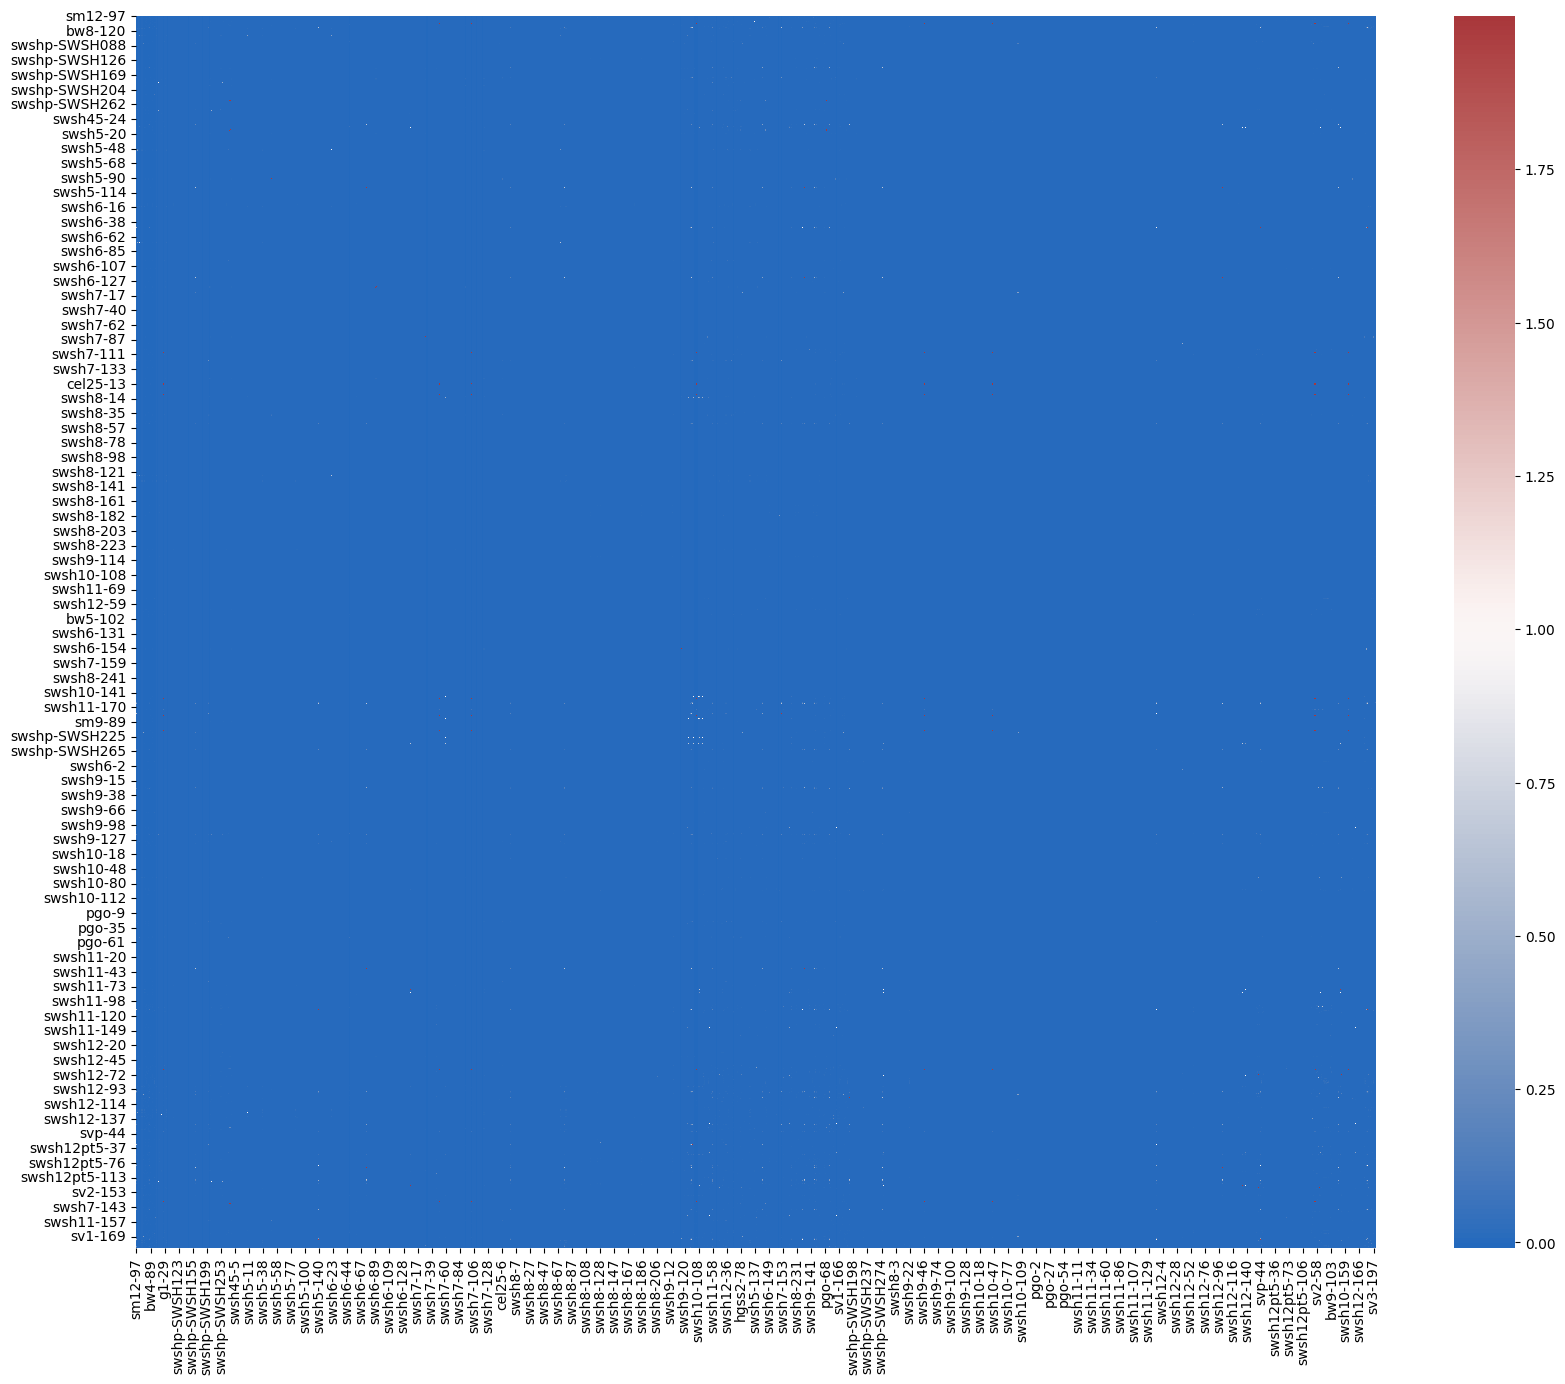

In [ ]:
fig = plt.figure(figsize=(20, 16))
sns.heatmap(differences, annot=False, cmap='vlag')
plt.show()

Top 10 true synergies

In [ ]:
def get_top_n_indices(data, n):
  data = np.array(data)
  top_n_values = sorted(np.unique(test_synergies_just_2023.to_numpy().flatten()))[-n:]
  data_mask = data > top_n_values[0]
  ret_rows = set([])
  ret_cols = set([])
  counter = 0
  for i in range(data.shape[0]):
    for j in range(data.shape[1]):
      if data_mask[i, j]:
        ret_rows.add(i)
        ret_cols.add(j)
  return ret_rows, ret_cols


In [ ]:
rows, cols = get_top_n_indices(test_synergies_just_2023, 10)

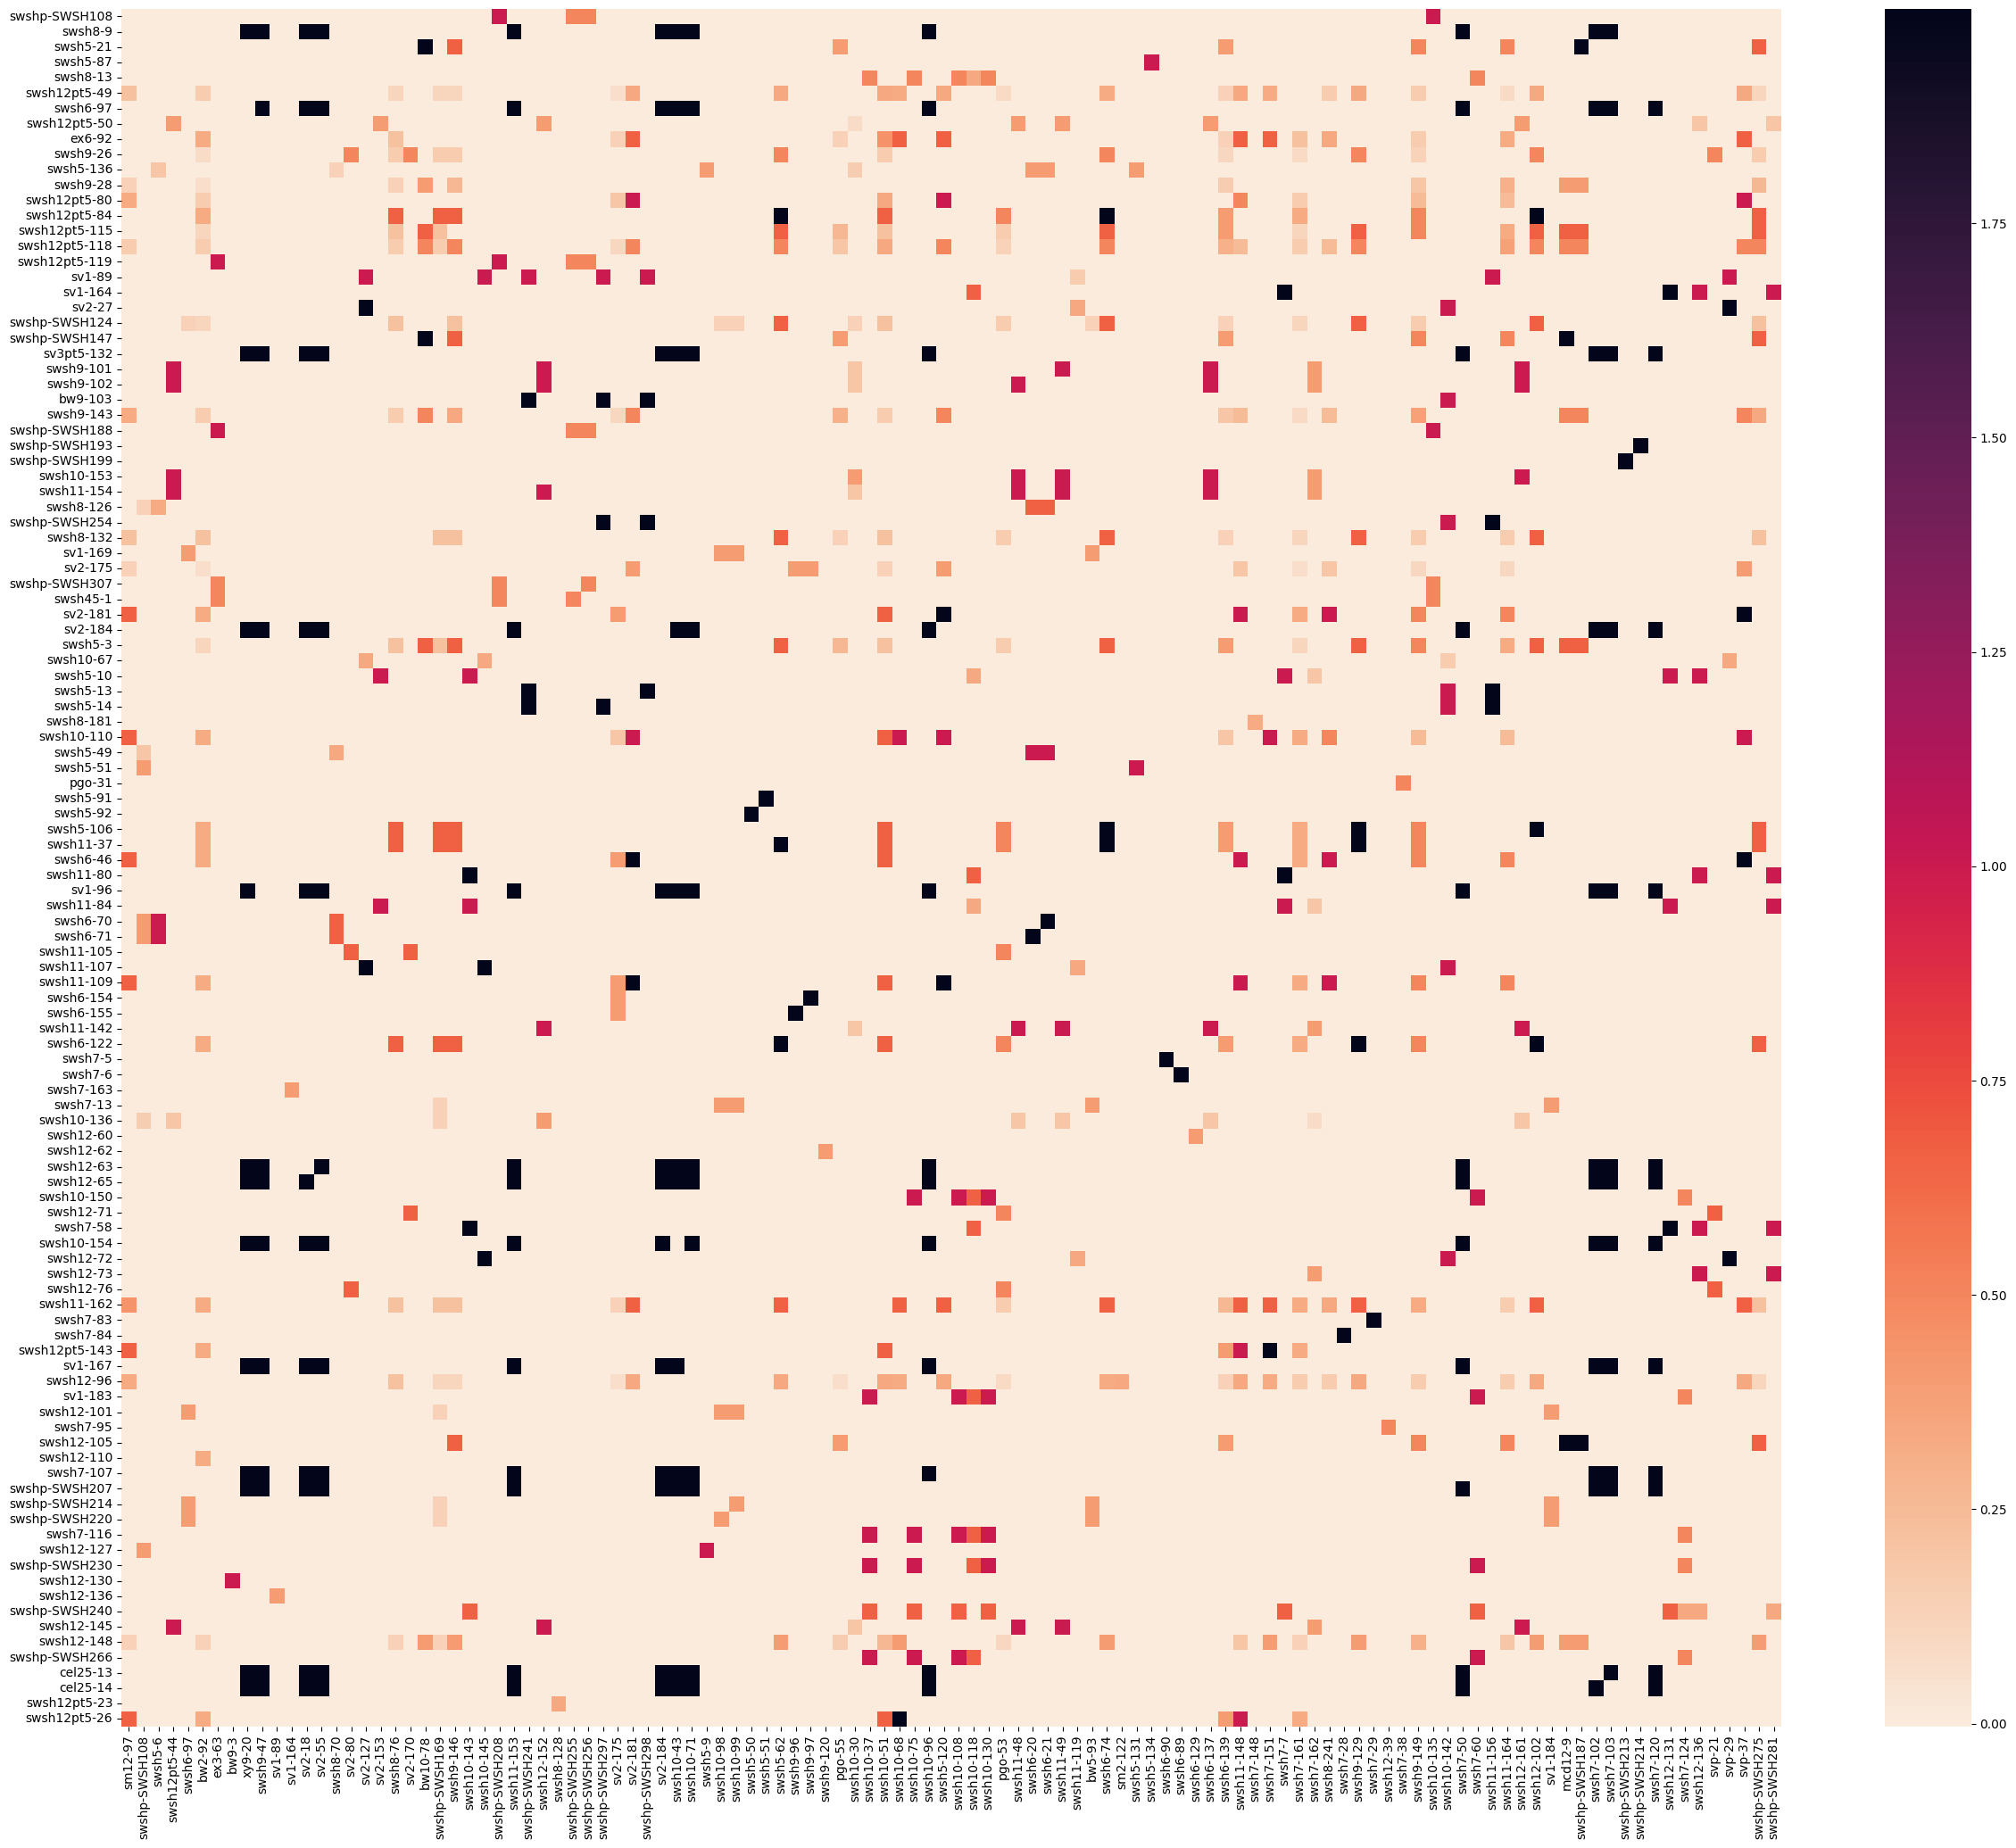

In [ ]:
fig = plt.figure(figsize=(30, 25))
sns.heatmap(differences.iloc[list(rows), list(cols)], annot=False, cmap='vlag')
plt.show()

In [ ]:
n = 10
lowest_n_values = sorted(np.unique(differences.to_numpy().flatten()))[:n]
mask = differences <= lowest_n_values[-1]
synergies = []
for card1 in differences.index:
  for card2 in differences.columns:
    if mask.loc[card1, card2]:
      print(card1, card2)
      synergies.append((card1, card2))
      if len(synergies) == n:
        break
  if len(synergies) == n:
        break

sm12-97 swsh6-136
swshp-SWSH108 swsh6-136
swsh5-6 swsh6-136
swsh5-22 swsh6-136
swsh5-87 swsh6-136
swsh6-97 swsh6-136
hgss1-96 swsh6-136
bw2-95 swsh6-136
bw4-89 swsh6-136
bw8-120 swsh6-136


In [ ]:
mask.sum().sum()

np.int64(0)